## Assignment: Image recognition
- Alumno 1: José Antonio Ruiz Heredia
- Alumno 2: Álvaro Honrubia
- Alumno 3: Hector Carlos Flores Reynoso 

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-04-09 21:25:44.249421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 21:25:44.261264: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 21:25:44.264960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 21:25:44.274447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [3]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [4]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    with rasterio.open('./xview_recognition/' + filename, 'r') as src_raster:
        input_type = src_raster.profile['dtype']
        input_channels = src_raster.count
        img = np.zeros((src_raster.height, src_raster.width, input_channels), dtype=input_type)
        for band in range(input_channels):
            img[:, :, band] = src_raster.read(band + 1)
    return img

#### Training
Design and train a CNN to deal with the “xview_recognition” classification task.

In [5]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [6]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [7]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [ ]:
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU, LeakyReLU, Rescaling
from keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomFlip
from keras.initializers import HeNormal
from keras.regularizers import L2
from keras.applications import ResNet50

base_model = ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-35:]:  # Fine-tune last 35 layers
    layer.trainable = True


# Create new model on top
inputs = Input(shape=(224, 224, 3))

x = RandomRotation(factor=0.1)(inputs)  
x = RandomTranslation(0.2, 0.2)(x)
x = RandomZoom(0.2)(x)
x = RandomFlip("horizontal")(x)

###################################
# Convolutional Feature Extractor #
###################################

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

##########################
# Fully Connected Layers #
##########################
# Hidden FC Layer 1

x = Dense(units=1024, kernel_initializer=HeNormal(), kernel_regularizer=L2(1e-5))(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(rate=0.4)(x)

# Hidden FC Layer 2
x = Dense(units=512, kernel_initializer=HeNormal(), kernel_regularizer=L2(1e-4))(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(rate=0.4)(x)

# Output layer
outputs = Dense(len(categories), activation='softmax')(x)
model = Model(inputs, outputs)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step 


/home/ec2-user/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_204         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,225,036 (100.04 MB)

 Trainable params: 2,633,228 (10.04 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [26]:
model.save('resnet.keras') 

In [9]:
from keras.optimizers import Adam

## Learning rate is changed (0.0001)
## beta 1: controls the exponential decay rate for the 1st moment (0.8)
## beta 2: controls the 2nd moment decay, fine-tuned for specific tasks. (0.999)
## epsilon: avoid numerical instability (1e-9)

opt = Adam(learning_rate=5e-4, beta_1=0.8, beta_2=0.999, epsilon=1e-9, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os
import datetime

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
## Change the factor to 0.5 and patience to 5 to make the learning rate decrease.
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.5, patience=5, verbose=1)
## Reduce the patience to stop early if the model doesn’t improve
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate, tensorboard_callback]

In [11]:
log_dir

'logs/20250409-212550'

In [12]:
def generator_images(objs, batch_size, categories, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                image = load_geoimage(filename).astype(np.float32) / 255.0  # Normalize manually

                # One-hot encode label
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                
                images.append(image)
                labels.append(probabilities)

            yield np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

In [13]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64 ## Increase bach size (128) 
train_generator = generator_images(objs_train, batch_size, categories, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, categories, do_shuffle=False)

In [14]:
import math
import numpy as np

print('Training model')
epochs = 100 ## Increase epochs (60) 
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/100


2025-04-09 21:26:03.899864: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1744233963.970964   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.985778   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.986923   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.988220   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.994502   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.996682   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233963.998343   61625 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744233964.038445   61625 gpu_

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4240 - loss: 2.0892 

W0000 00:00:1744234008.086087   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.087059   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.087868   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.088822   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.089765   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.090702   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.091808   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.093106   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234008.094309   61623 gp

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4242 - loss: 2.0881

W0000 00:00:1744234009.103692   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.104146   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.104580   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.105044   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.105545   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.106091   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.106574   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.106997   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234009.107443   61623 gp


Epoch 1: val_accuracy improved from -inf to 0.62582, saving model to model.keras


W0000 00:00:1744234018.001845   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.002534   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.003161   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.011547   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.011888   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.012219   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.012551   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.012883   61623 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744234018.013212   61623 gp

301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.4244 - loss: 2.0871 - val_accuracy: 0.6258 - val_loss: 1.2648 - learning_rate: 5.0000e-04
Epoch 2/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5366 - loss: 1.4844 
Epoch 2: val_accuracy improved from 0.62582 to 0.66090, saving model to model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 57s 189ms/step - accuracy: 0.5366 - loss: 1.4843 - val_accuracy: 0.6609 - val_loss: 1.1248 - learning_rate: 5.0000e-04
Epoch 3/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5637 - loss: 1.4068 
Epoch 3: val_accuracy did not improve from 0.66090
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 180ms/step - accuracy: 0.5637 - loss: 1.4068 - val_accuracy: 0.6413 - val_loss: 1.1397 - learning_rate: 5.0000e-04
Epoch 4/100
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5804 - loss: 1.3698 
Epoch 4: val_accuracy did not improve from 0.66090
301/301 ━━━━━━━━━━━━━━━━━━━━ 54s 179ms/step - accuracy: 0.5804 - loss: 1.3698 - val_accuracy: 0.6604

In [15]:
# Save history as JSON
with open('training_history.json', 'w') as f:
    json.dump(h.history, f)

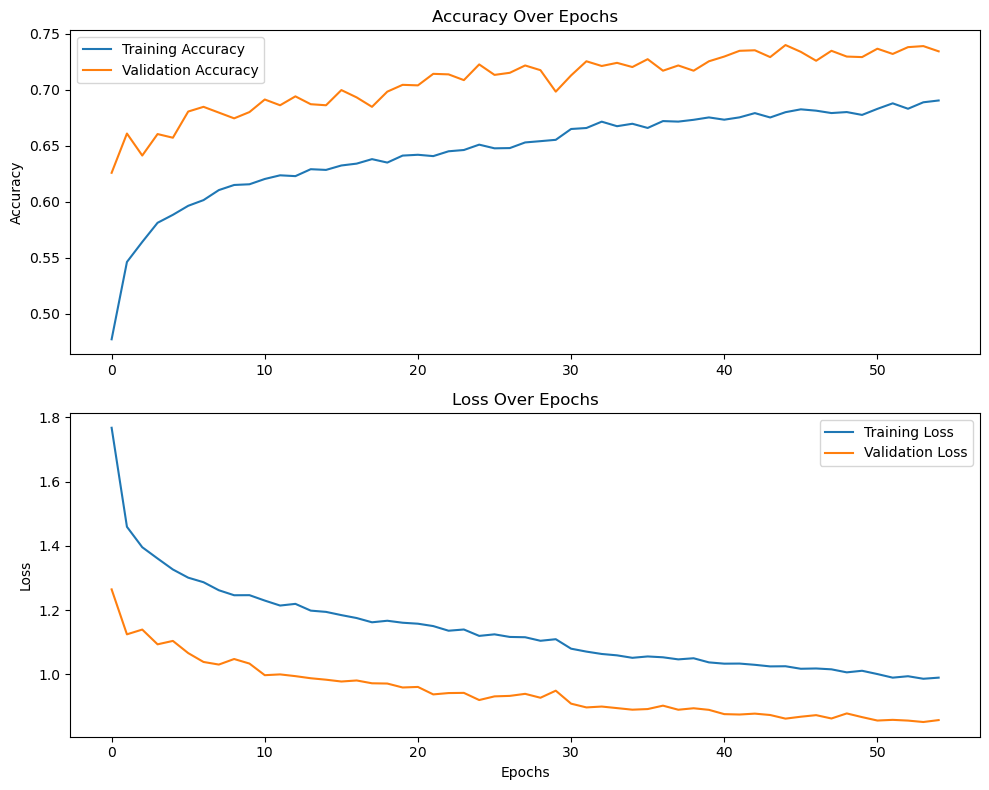

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(10, 8))

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

#### Validation
Compute validation metrics.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    fig.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show(fig)

In [18]:
import numpy as np

model.load_weights('./model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

W0000 00:00:1744237013.299737   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.300133   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.300451   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.300772   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.301118   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.301444   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.301763   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.302111   61622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1744237013.302455   61622 gp

/tmp/ipykernel_61589/556401719.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


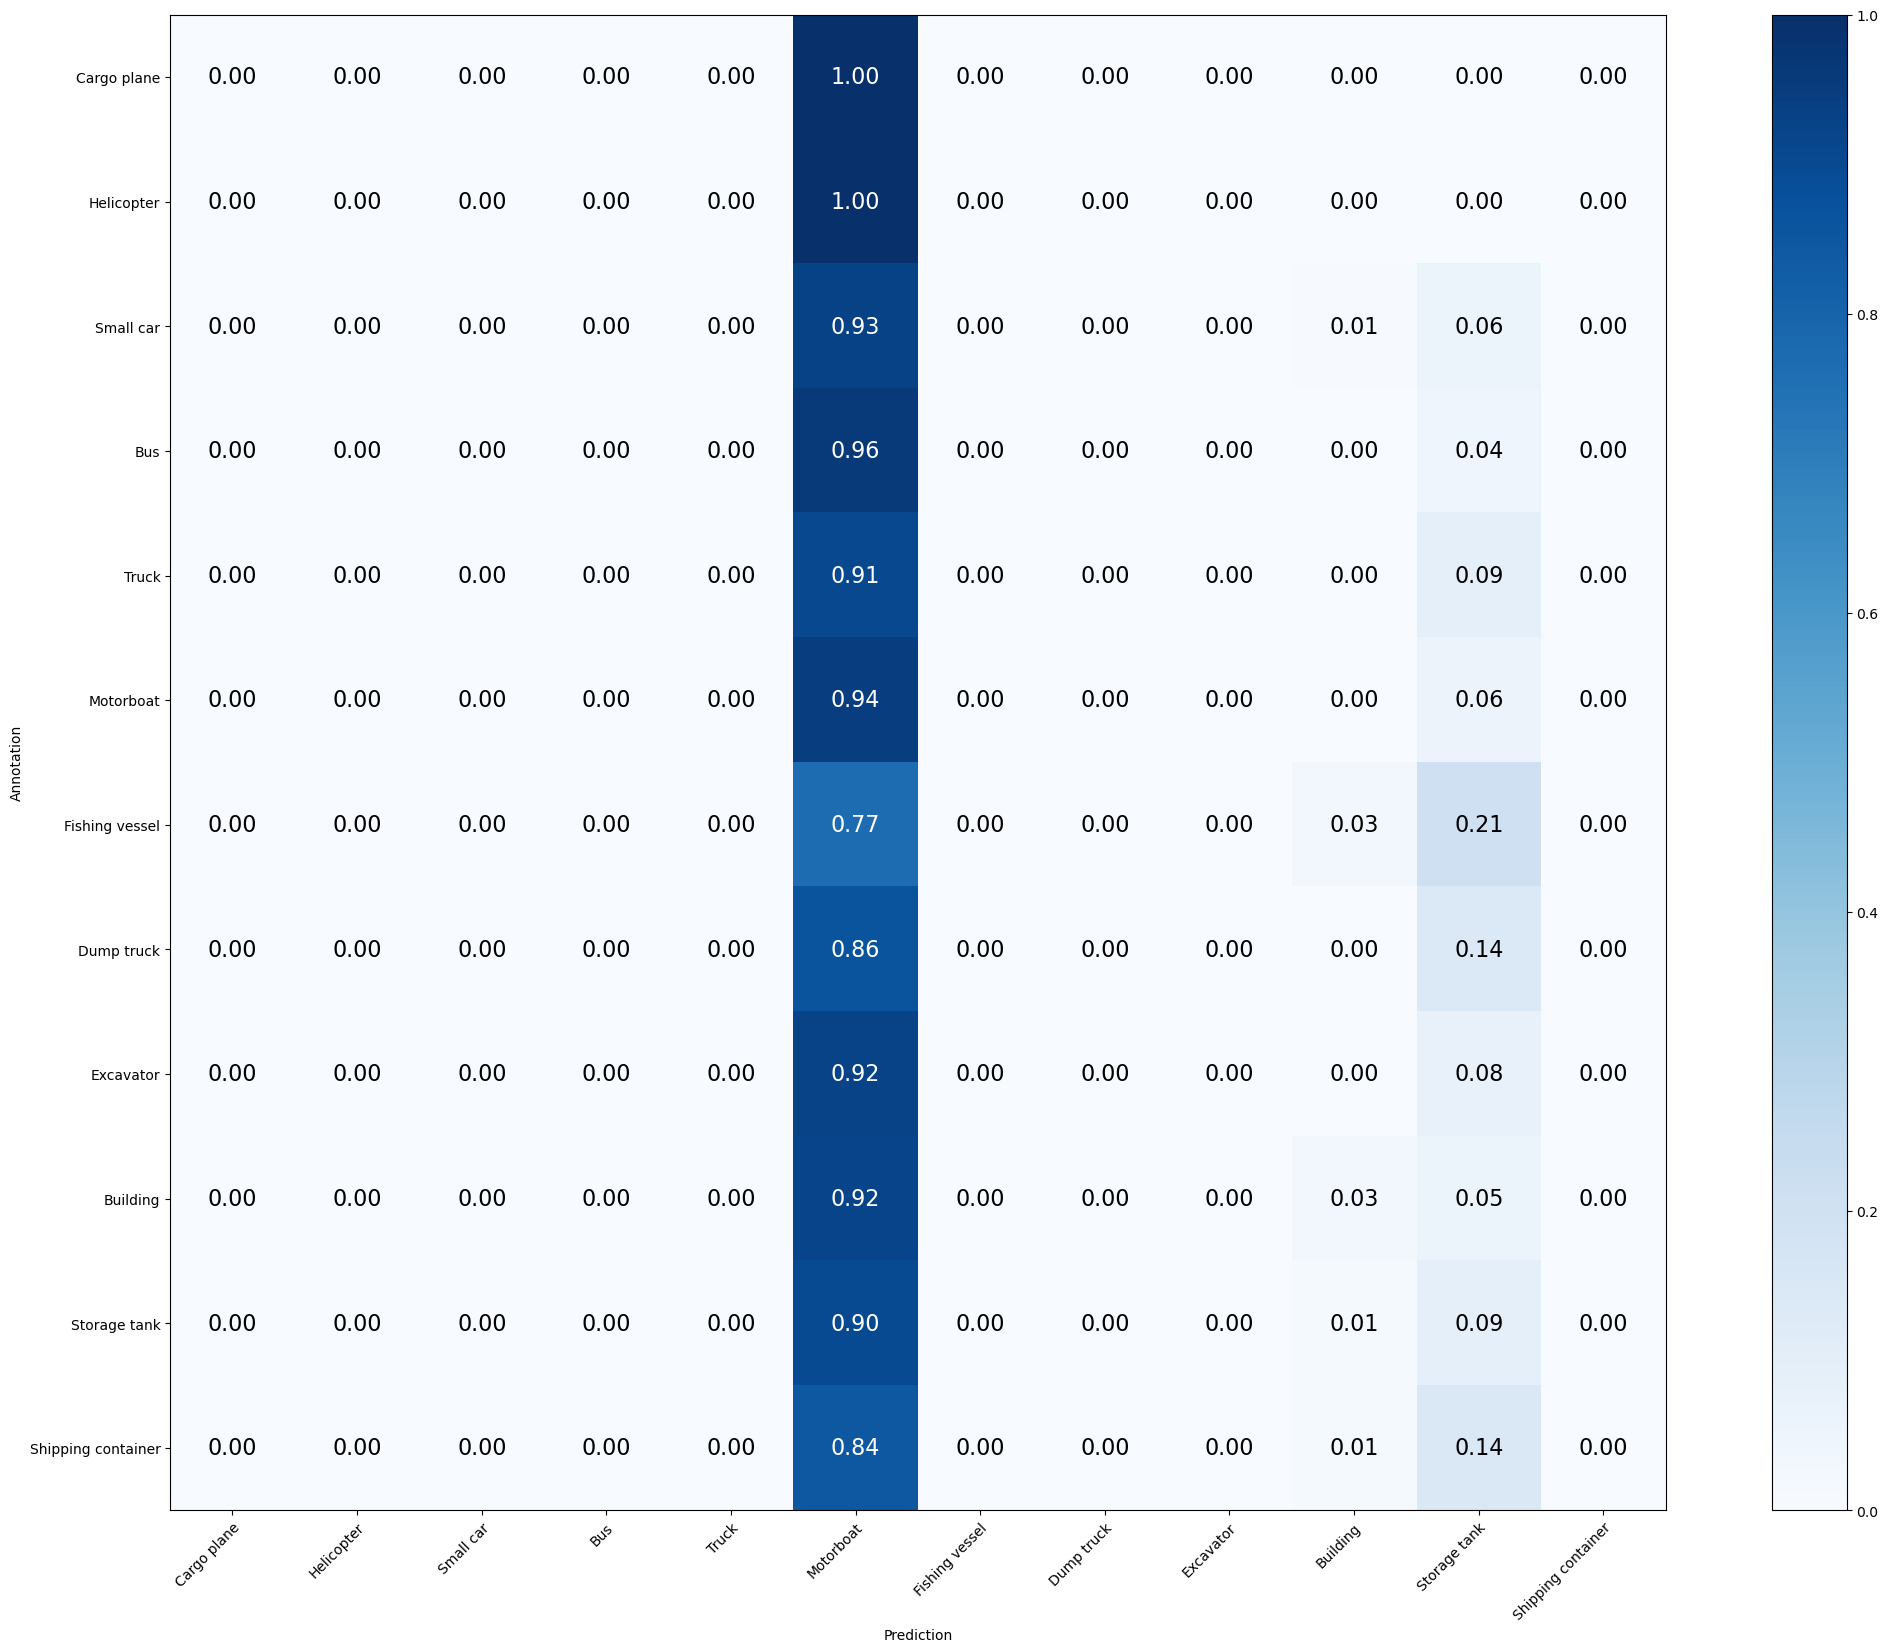

In [19]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [20]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 5.239%
Mean Recall: 8.863%
Mean Precision: 5.932%
> Cargo plane: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Bus: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Motorboat: Recall: 94.382% Precision: 4.310% Specificity: 8.980% Dice: 8.243%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 99.951% Dice: 0.000%
> Dump truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Building: Recall: 2.823% Precision: 58.333% Specificity: 99.391% Dice: 5.385%
> Storage tank: Recall: 9.150% Precision: 8.537% Specificity: 92.443% Dice: 8.833%
> Shipping container: Recall: 0.000% Precision

#### Testing
Try to improve the results provided in the competition.

In [21]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('./xview_recognition/xview_test'):
    for filename in filenames:
        image_path = os.path.relpath(os.path.join(dirpath, filename), './xview_recognition/')
        image = GenericImage(image_path)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [22]:
import numpy as np

model.load_weights('./model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [23]:
with open("./prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)